# Tutorial 3

In this tutorial, we would apply our knowledge of GNN to solve a classic power system problem: Optimal Power Flow (OPF)

OPF is concerned with determining the optimal scheduling of generation which satisfies the network demand and minimizes generation cost.
Here, we would be using data generated using standard OPF solver. We would train a GNN model to predict the optimal generator set points.
    
This is an example of node regression task.

In [1]:
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
# !pip install torch_geometric
# !pip install gurobipy

In [3]:
# import all libraries needed later
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
import gurobipy as gp
import networkx as nx
from torch_geometric.nn import ChebConv, GraphConv, GCNConv
from torch.nn import Linear
from torch_geometric.data import Data
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time

#### Function to read network connectivity and demand data

In [4]:
def read_data(File='IEEE_14_bus_Data.xlsx',print_data=False,DemFactor=1.0,LineLimit=1.0):
    # read the data file and convert it into a dictionary of dataframes 
    
    Sbase=100
    
    data={}
    
    Bus=pd.read_excel(File,sheet_name='Bus',skiprows=0,index_col=[0],usecols='A')
    Bus=list(Bus.index)           
    
    
##============================ Branch ========================
    # branch is a dataframe that shows r,x,limit of branches
    branch=pd.read_excel(File,sheet_name='Branch',skiprows=1,index_col=[0,1,2],usecols='A:F')
    line=pd.read_excel(File,sheet_name='Branch',skiprows=1,index_col=0,usecols='A')
    line=list(line.index)

    branch['limit']=(LineLimit*branch['limit'])/Sbase


    br_list=list(branch.index)
    Lines=gp.tuplelist(br_list)   #Lines is a gurobipy tupilelist that shows CONECCTIVITY of the network



    L2B=[]   #set all lines connected to bus b
    LFr2B=[]   #set lines from bus b
    LTo2B=[]   #set lines to bus b

    for l,i,j in Lines:
        LFr2B=LFr2B+[(l,i)]
        LTo2B=LTo2B+[(l,j)]
        L2B=L2B+[(l,i)]
        L2B=L2B+[(l,j)]
    L2B=gp.tuplelist(L2B)          # Set lines connected to each bus (substation)
    LFr2B=gp.tuplelist(LFr2B)
    LTo2B=gp.tuplelist(LTo2B)

    NumberL2B=dict.fromkeys(Bus)    #number of connected lines to each bus (substation)
    for i in NumberL2B.keys():
        n=0
        NumberL2B[i]=n
        for l in L2B.select('*',i):
            n+=1
            NumberL2B[i]=n
    


# Demand Set


    Pdemand=pd.read_excel(File,sheet_name='DemandSet',skiprows=1,index_col=2,usecols='A:E')
    Pdemand.drop(columns=['Unnamed: 0','Unnamed: 1'],axis=1,inplace=True)
    Pdemand.rename(columns={1:'Pd'})
    Pdemand.fillna(0,inplace=True)
    Pdemand['Pd']=(DemFactor*Pdemand['Pd'])/Sbase         

    DemandSet=list(Pdemand.index)                       

    D2B_df=pd.read_excel(File,sheet_name='D2B',skiprows=0,index_col=[1,2])
    d2b_list=list(D2B_df.index)
    D2B=gp.tuplelist(d2b_list)



#==================================== Generation data =============
# Gen_data is a DF that shows generators data

    Gen_data=pd.read_excel(File,sheet_name='Gen',skiprows=2,index_col=0,usecols='A:E')
    Gen_data['Pmax']=Gen_data['Pmax']/Sbase
    Gen_data['Pmin']=Gen_data['Pmin']/Sbase
    Gen_data['a']=Gen_data['a']*Sbase             #The final objective cost should be multiplied with Sbase 
    G=list(Gen_data.index) #Set Generation

  


    # G2B is a GP object showing Gen-2-bus
    G2B_df=pd.read_excel(File,sheet_name='G2B',skiprows=0,index_col=[1,2])
    g2b_list=list(G2B_df.index)
    G2B=gp.tuplelist(g2b_list)
    
    
    if print_data==True:
        display(Pdemand)
        display(branch)
        display(Gen_data)
        
    
    data['Sbase']=Sbase
    data['Bus']=Bus    # for b in Bus
    data['branch']=branch
    data['Lines']=Lines
    data['line']=line
    data['L2B']=L2B
    data['LFr2B']=LFr2B
    data['LTo2B']=LTo2B
    data['NumberL2B']=NumberL2B
    data['Pdemand']=Pdemand
    data['Demandset']=DemandSet   
    data['D2B']=D2B                  
    data['Gen_data']=Gen_data
    data['G']=G                
    data['G2B']=G2B              
    
    
    return data 

#### Function to construct networkx graph

In [5]:
# function to build networkx graph from adjacency matrix
def Build_graph(data,weighted=False):

    nodes=data['Bus']
    Lines=data['Lines']

    node_list=nodes.copy()

    graph=nx.Graph()

    if weighted==False:
        edge_list=[]
        for l,i,j in Lines:
            graph.add_edge(i, j, weight=1)

        graph.add_nodes_from(node_list)

    if weighted==True:
        edge_list=[]
        for l,i,j in Lines:
            graph.add_edge(i, j, weight=data['branch'].loc[(l,i,j)]['x'])

        graph.add_nodes_from(node_list)
        #graph.add_edges_from(edge_list)

    return graph

In [8]:
# provide the correct path to the excel file and the npz file
data_file = 'IEEE_14_bus_Data.xlsx'
opf_dataset = 'DataSet_14bus_OPF.npz'
data_x_bus = read_data(File=data_file,DemFactor=1.0,print_data=False)
dataset=np.load(opf_dataset)

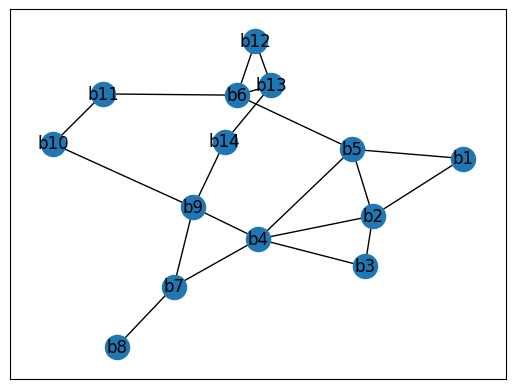

In [9]:
graph=Build_graph(data_x_bus, weighted=True)
nx.draw_networkx(graph)

#### Function to generate training data

The function is the network data and the OPF data. The OPF data contains the set of demands at different times and the solution to the OPF problem solved with Gurobipy solver. These will be the training features and labels of our graph neural network

In [10]:
# function to create GNN graph data
def Generate_GNN_Training_Data(networkdata,dataset,seed=1):

    """
    Input: The dataset of demand, and the solution of the OPF problem solved Gurobipy solver.
    Output: a dictionary of {Xd,Xg,G2N,yg}

    The Xd is the demand
    The Xg is a set of generator features, we would not use these
    The G2N is a vector of nodes which are generator nodes

    The yg is the predicted generator set point

    """

    Bus=networkdata['Bus']
    Gen=networkdata['G']
    Gen_data=networkdata['Gen_data']
    DemandSet=networkdata['Demandset']
    D2B=networkdata['D2B']
    G2B=networkdata['G2B']
    Bus=networkdata['Bus']
    Nload=len(networkdata['Demandset'])
    Nbus=len(networkdata['Bus'])

    Xdata,ydata = dataset['arr_0'], dataset['arr_1']
    print(f"Reading dataset ... \n X_dataset shape is: {Xdata.shape} , y_dataset shape is: {ydata.shape}")

    data_len=len(Xdata)
    
    Nsamples=data_len

    Xd=np.zeros(shape=(Nsamples,len(Bus)))
    Gfeatures=3
    Xg=np.zeros((Nsamples,len(Bus),Gfeatures))

    df=Gen_data['b']
    normalized_b=(df-df.min())/(df.max()-df.min())

    for b_ind,b in enumerate(Bus):
        for g,b in G2B.select('*',b):
            Xg[:,b_ind,0]=normalized_b.loc[g].astype(np.float32) # 1st feature is b price
            Xg[:,b_ind,1]=Gen_data['Pmax'].loc[g].astype(np.float32) # 2nd feature is Pmax value


    yg=np.zeros((Nsamples,len(Gen)))

    G2N=np.zeros((len(Bus)) )

    graph_dict={}
    graph_weighted_dict={}
    Adj_dict={}
    Adj_weighted_dict={}

    for b_ind,b in enumerate(Bus):
        for g,b in G2B.select('*',b):
            G2N[b_ind]=1

    # graph
    graph=Build_graph(networkdata,weighted=False) 
    graph_weighted=Build_graph(networkdata,weighted=True)
    Adj_mat=nx.to_numpy_array(graph)
    Adj_weighted_mat=nx.to_numpy_array(graph_weighted)



    for sample in range(Nsamples):
        Xd[sample,:]=Xdata[sample,: ].T

        yg[sample,:]=ydata[sample,: ].T

        #graph
        graph_dict[sample]=graph
        graph_weighted_dict[sample]=graph_weighted
        Adj_dict[sample]=Adj_mat
        Adj_weighted_dict[sample]=Adj_weighted_mat


    #shuffle the data:
    np.random.seed(seed)
    permutation_index = np.random.permutation(Nsamples)

    Xd=Xd[permutation_index,:]
    yg=yg[permutation_index,:]
    Xg=Xg[permutation_index,:]


    return {
        'Xd':Xd,
        'Xg':Xg,
        'G2N':G2N,
        'yg':yg,
        'graph':graph,
        'graph_weighted':graph_weighted_dict,
        'Adj':Adj_mat,
        'Adj_weighted':Adj_weighted_dict

    }

In [11]:
## specify the system size = number of nodes in the network
system_size=14

In [12]:
data =Generate_GNN_Training_Data(data_x_bus,dataset)

Reading dataset ... 
 X_dataset shape is: (2192, 14) , y_dataset shape is: (2192, 5)


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Function to create graph data

Here we use pytorch geometric's Data module to create graph data objects. Each object is made up of the demands at all nodes (x), the predicted generator output at generator nodes (y) and the weighted adjacency matrix (edge_list)

In [23]:
# function to create graph dataset
def create_graph_data(graph,input_x,output_x, train_size, val_size, test_size, edge_list, edge_weights):

    train_dataset = []
    val_dataset = []
    test_dataset = []

    edge_list = [[edge[0], edge[1]] for edge in edge_list]
    edge_list = torch.tensor(np.array(edge_list).T, dtype=torch.int64)
    edge_attr = torch.tensor(np.array(edge_weights)).reshape(len(edge_weights),-1)

    for i in range(input_x.shape[0]):
        if i < train_size:
            train_dataset.append(Data(x=input_x[i].float(), y=output_x[i].float(), edge_index=edge_list))
        elif i < train_size + val_size:
            val_dataset.append(Data(x=input_x[i].float(), y=output_x[i].float(), edge_index=edge_list))
        else:
            test_dataset.append(Data(x=input_x[i].float(), y=output_x[i].float(), edge_index=edge_list))
    return train_dataset, val_dataset, test_dataset

In [24]:
# This is the  GNN object class, # graph conv layers where each graph convolution layer only exchanges information with it's immediate neighbour
# Power networks are typically shallow graphs
# The output of convolutional layers are passed through linear layers to get the correct output shape
class VanillaGNN(torch.nn.Module):

    def __init__(self, network_size, num_features, num_of_outputs,gen_nodes, conv_hid_features=32, lin_hid_features=256):
        super(VanillaGNN, self).__init__()
        self.network_size = network_size
        self.num_features = num_features
        self.conv_hid_features = conv_hid_features
        self.lin_hid_features = lin_hid_features
        self.output_dim = num_of_outputs
        self.gen_nodes=gen_nodes

        self.conv1 = ChebConv(self.num_features, self.conv_hid_features, K=3)
        self.conv2 = ChebConv(self.conv_hid_features, self.conv_hid_features, K=3)
        # self.conv3 = ChebConv(self.conv_hid_features, self.conv_hid_features, K=3)


        self.lin1 = Linear(self.conv_hid_features*(self.network_size), self.lin_hid_features)
        self.lin2 = Linear(self.lin_hid_features,self.output_dim*len(self.gen_nodes))


    def forward(self, data):

        x = data.x[:]
        
        x = x.reshape(-1,1)

        edge_index = data.edge_index
        batch_size = int(len(data.batch)/self.network_size)

        x = self.conv1(x=x, edge_index=edge_index)
        x = x.relu()
        x = self.conv2(x=x, edge_index=edge_index)
        x = x.relu()

        x=x.reshape(batch_size,-1)

        x = self.lin1(x)

        x = self.lin2(x)
        
        output = torch.flatten(x)
        
        output = output.float()
        
        return output

In [25]:
# function for model training , returns loss per epoch after summing loss per batch and dividing by number of batches in data loader object
def train_epoch(model, loader, optimizer, device=device):
    model.to(device)
    model.train()

    epoch_loss = 0

    for batch in loader:
        data = batch.to(device)
        y = batch.y.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        y_pred = y_pred.to(device)
        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [26]:
# function for model validation , returns loss per epoch after summing loss per batch and dividing by number of batches in data loader object
def evaluate_epoch(model, loader, device=device):


    torch.no_grad()
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode

    epoch_loss = 0

    model.eval()

    with torch.no_grad():

        for batch in loader:

            data = batch.to(device)
            y = batch.y.to(device)
            y_pred = model(data)
            y_pred = y_pred.to(device)
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [27]:
# function to run trained model through test data, save model prediction per batch and true generator outputs to list
def test_model(model, loader, device=device):


    torch.no_grad()
    model.to(device)

    epoch_loss = 0
    model_preds = []
    actual_y = []

    model.eval()

    with torch.no_grad():

        for batch in loader:

            data = batch.to(device)
            y = batch.y.to(device)
            actual_y.append(y)
            y_pred = model(data)
            model_preds.append(y_pred)
            y_pred = y_pred.to(device)
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()

    return epoch_loss / len(loader),model_preds, actual_y

#### Function to manually optimizing parameters

We would not perform hyperparamater tuning right away. See if you can improve the model performance by running several iterations of hyperparameter combinations.

In [28]:
from itertools import product
# function to create multiple run instances of model training for best hyperparameter selection
def create_hyper_combination():
    parameters = dict(
      batch_size = [16],
      conv_hid_features=[h_feat],
      lin_hid_features=[l_feat]
  )

    param_values = [v for v in parameters.values()]
    print(param_values)

    for batch_size, conv_hid_features, lin_hid_features in product(*param_values):
        print(batch_size, conv_hid_features, lin_hid_features)

    return param_values



### Main training function

In [35]:
def run_model(data, batch_size, conv_hid_features, lin_hid_features, seed=1,epochs=100):

    node_demand_features= data['Xd']
    generator_features = data['Xg']
    predicted_generation = data['yg']
    generator_nodes = data['G2N']
    A_matrix = data['Adj']

    gen_nodes = np.nonzero(generator_nodes)
    gen_nodes = gen_nodes[0].tolist()

    edge_labels = nx.get_edge_attributes(graph, "weight")

    edge_list = [i for i in edge_labels.keys() ]

    edge_list = [(i[0][1:], i[1][1:]) for i in edge_list]
    edge_list = [(int(i[0])-1, int(i[1])-1) for i in edge_list]
    edge_weights = [i for i in edge_labels.values() ]

    torch.manual_seed(seed)

    model = VanillaGNN(system_size,1, 1, gen_nodes, conv_hid_features=h_feat, lin_hid_features=l_feat).to(device)
    print(model)

  # count the number of parameters in this model
    tot_params = 0
    for parameter in model.parameters():
        layer_ws = 1
        for val in parameter.shape:
            layer_ws*=val
        tot_params += layer_ws
    print(f"Total number of parameters = {tot_params}")


    input_x = torch.tensor(node_demand_features)
    gen_x=torch.tensor(generator_features)



    output_x = torch.tensor(predicted_generation)
    output_x = output_x.reshape(predicted_generation.shape[0],-1)


    train_size = (input_x.shape[0]//3) * 2
    val_size = (input_x.shape[0]//3) / 2
    test_size = (input_x.shape[0]//3) / 2



    train_dataset, val_dataset, test_dataset = create_graph_data(graph,input_x,output_x, train_size, val_size,test_size, edge_list, edge_weights)

  # =========================================== Training ============================================================================

    start=time.time()
    model = VanillaGNN(system_size,1, 1, gen_nodes, conv_hid_features=conv_hid_features, lin_hid_features=lin_hid_features).to(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-5)
    criterion = torch.nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

    epochs = epochs

    training_losses = []
    validation_losses = []
    for epoch in range(epochs+1):
        train_loss = train_epoch(model, train_loader, optimizer)
        valid_loss = evaluate_epoch(model, val_loader)
        training_losses.append(train_loss)
        validation_losses.append(valid_loss)
        scheduler.step(valid_loss)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}')
            print(f'\tTrain Loss: {train_loss:.4f}')
            print(f'\t Val. Loss: {valid_loss:.4f}')


    end=time.time()

    plt.subplots(figsize=(5,3))
    plt.plot([i for i in range(len(training_losses))], training_losses, 'r', label='Training loss', linestyle='solid')
    plt.plot([i for i in range(len(validation_losses))], validation_losses, 'g', label='Validation loss', linestyle='dashed')
    plt.legend()
    plt.title(f'GCN Training and Validation loss for {system_size} Bus system',fontsize = 15)
    plt.xlabel('Epochs',fontsize = 12)
    plt.ylabel('MSE Loss',fontsize = 12)
    plt.show()
    print('Training time is: %.2f'%(end-start))

    training_losses=np.array(training_losses)
    validation_losses=np.array(validation_losses)


    #========================== Testing ============================
    test_loss,output_list, y_list = test_model(model, test_loader)

    # reshape predicted generator output test data from batches in lists to original shape
    actual_output_tensor = torch.zeros(len(test_dataset),len(gen_nodes))
    count= 0
    for batch in output_list:
            single_batch = batch.reshape(len(gen_nodes),-1)
            single_batch = single_batch.permute(1,0)
            for instance in range(single_batch.shape[0]):
                actual_output_tensor[count,:] = single_batch[instance]
                count += 1


    # reshape true generator output test data from batches in lists to original shape
    pred_y_tensor = torch.zeros(len(test_dataset),len(gen_nodes))
    count= 0
    for batch in y_list:
            single_batch = batch.reshape(len(gen_nodes),-1)
            single_batch = single_batch.permute(1,0)
            for instance in range(single_batch.shape[0]):
                pred_y_tensor[count] = single_batch[instance]
                count += 1


    # calculate and print MSE loss for test data not used during training
    final_test_loss = criterion(actual_output_tensor, pred_y_tensor)
    final_test_loss = np.array(final_test_loss)
    print('final_test_loss is : ', final_test_loss)


    return {
        'training_losses':training_losses,
        'validation_losses':validation_losses,
        'final_test_loss':final_test_loss,
        'y_test':pred_y_tensor,
        'y_pred':actual_output_tensor
    }






### Call function to train model and print results

[[16], [32], [16]]
16 32 16
run id: 1


	=============== Run 1, Seed 1 =============== 


VanillaGNN(
  (conv1): ChebConv(1, 32, K=3, normalization=sym)
  (conv2): ChebConv(32, 32, K=3, normalization=sym)
  (lin1): Linear(in_features=448, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=5, bias=True)
)
Total number of parameters = 10501
Epoch: 0
	Train Loss: 0.2550
	 Val. Loss: 0.1580
Epoch: 10
	Train Loss: 0.0016
	 Val. Loss: 0.0013
Epoch: 20
	Train Loss: 0.0012
	 Val. Loss: 0.0010
Epoch: 30
	Train Loss: 0.0012
	 Val. Loss: 0.0010
Epoch: 40
	Train Loss: 0.0011
	 Val. Loss: 0.0010
Epoch: 50
	Train Loss: 0.0011
	 Val. Loss: 0.0010


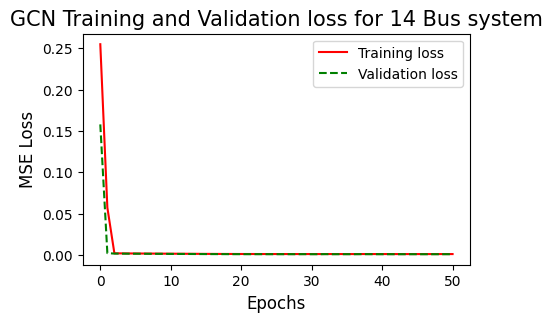

Training time is: 45.43
final_test_loss is :  0.001084611


In [36]:
criterion = torch.nn.MSELoss()
h_feat=32
l_feat=16

param_values = create_hyper_combination()

NumRuns = 1

epochs=50

train_loss_array=np.zeros((NumRuns,epochs+1))
val_loss_array=np.zeros((NumRuns,epochs+1))
test_loss_array=np.zeros((NumRuns))

for run_id, (batch_size, conv_hid_features, lin_hid_features) in enumerate(product(*param_values)):

    seed=run_id + 1
    print(f'\n\n\t=============== Run {run_id + 1}, Seed {seed} =============== \n\n')

    result=run_model(data,batch_size, conv_hid_features, lin_hid_features, seed=seed,epochs=epochs)

    train_loss_array[run_id,:]=result['training_losses']
    val_loss_array[run_id,:]=result['validation_losses']
    test_loss_array[run_id]=result['final_test_loss']

### Try other PyG modules

Take a look at other available Graph neural network modules available in PyG here: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html

Try a different module and see if you can further improve the model performance.

Thank you for your participation!